# XGBoost

In [1]:
import pandas as pd

In [2]:
all = pd.read_csv('../expedia_data/all_data.csv')
all.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,new_comp5_rate_percent_diff,new_comp6_rate,new_comp6_inv,new_comp6_rate_percent_diff,new_comp7_rate,new_comp7_inv,new_comp7_rate_percent_diff,new_comp8_rate,new_comp8_inv,new_comp8_rate_percent_diff
0,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,24202,3,0.0,...,0,0,0,0,0,0,0,0,0,0
1,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,52429,4,4.0,...,0,0,0,0,0,0,0,0,0,0
2,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,140423,3,4.0,...,0,0,0,0,0,0,0,0,0,0
3,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,135609,4,4.0,...,0,0,0,0,0,0,0,0,0,0
4,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,129319,4,5.0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [4]:
all.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,new_comp5_rate_percent_diff,new_comp6_rate,new_comp6_inv,new_comp6_rate_percent_diff,new_comp7_rate,new_comp7_inv,new_comp7_rate_percent_diff,new_comp8_rate,new_comp8_inv,new_comp8_rate_percent_diff
0,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,24202,3,0.0,...,0,0,0,0,0,0,0,0,0,0
1,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,52429,4,4.0,...,0,0,0,0,0,0,0,0,0,0
2,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,140423,3,4.0,...,0,0,0,0,0,0,0,0,0,0
3,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,135609,4,4.0,...,0,0,0,0,0,0,0,0,0,0
4,365278,2012-11-01 00:01:37,24,216,NaN,NaN,225,129319,4,5.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print('Dataset has %d record'%len(all))
print('Dataset has %d search_id (accounts)'%len(all['srch_id'].unique().tolist()))

Dataset has 908750 record
Dataset has 36518 search_id (accounts)


In [6]:
variables = [col for col in all.columns.unique().tolist() if col not in ['price_usd','date_time']]

In [7]:
# get sampled data
def get_sampled_data(size, data):
    '''
    This function takes in the whole dataset, 
    and outout a sampled subset with data size specified
    '''
    interval_range = len(data)//size
    mid_idx_lst = []
    for i in range(1,size+1):
        mid_idx = (interval_range*(i-1) + interval_range*i)//2
        mid_idx_lst.append(mid_idx)

#     print(mid_idx_lst[0],mid_idx_lst[-1])
    data_sampled = data.iloc[mid_idx_lst]
    return data_sampled
    
sampled = get_sampled_data(5000, all)

In [9]:
data_dmatrix = xgb.DMatrix(data=X,label=y, feature_names=variables)

In [17]:
# add test set

def split_data(data):
    '''
    This function takes in the whole data set and divide it into training, validation and test data;
    split into 0.8 and 0.2 first; second split using the same ratio into training and valiation
    '''
    training_size_large = int(len(data) * 0.8)   
    validation_size = int(training_size_large * 0.2)
    training_size = training_size_large - validation_size
    test_size = int(len(data) * 0.2)
    
    print('training size: %d'%training_size)
    print('validation size: %d'%validation_size)
    print('test size: %d'%test_size)
    
    # split data manually
    training_data = data[0: training_size]
    validation_data = data[training_size:(training_size + validation_size)]
    test_data = data[(training_size + validation_size): (training_size + validation_size + test_size)]
    
    return training_data, validation_data, test_data
    
training, validation, test = split_data(sampled)

training size: 3200
validation size: 800
test size: 1000


In [18]:
X_train = training[variables].values
y_train = training['price_usd'].values

X_val = validation[variables].values
y_val = validation['price_usd'].values

X_test = test[variables].values
y_test = test['price_usd'].values

In [19]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, preds))
print("validation RMSE: %f" % (rmse_val))

preds = xg_reg.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, preds))
print("training RMSE: %f" % (rmse_train))

validation RMSE: 562.349197
training RMSE: 3913.465170


In [20]:
### increase max_depth = 10
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
            max_depth=10, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, preds))
print("validation RMSE: %f" % (rmse_val))

### get training set RMSE
preds = xg_reg.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, preds))
print("training RMSE: %f" % (rmse_train))

validation RMSE: 676.030753
training RMSE: 3751.740611


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

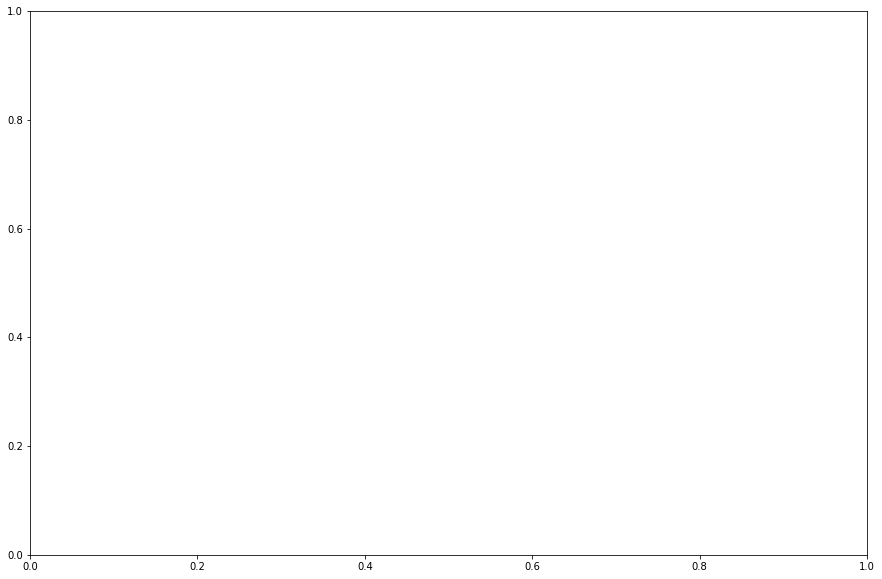

In [84]:
### visualize the results
### graphviz not working, need to fix this
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

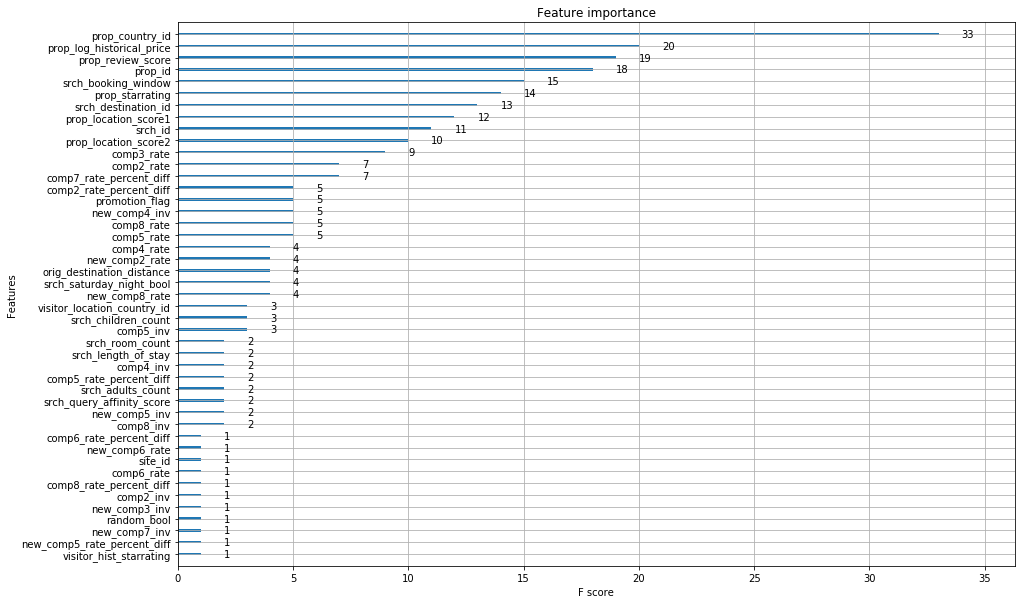

In [83]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

用XGBoost实现gradient boosted decision trees：<br>
参考：https://www.datacamp.com/community/tutorials/xgboost-in-python